In [1]:
from copy import deepcopy
import random
import numpy as np
import scipy.stats as ss
import math
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/home/sungnyun/custom_turbo/")
#sys.path.insert(0, "/home/nakyil/jupyter/git_repo/bbo/custom_turbo/")

from turbo import Turbo1
from turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube

from bayesmark.abstract_optimizer import AbstractOptimizer
from bayesmark.experiment import experiment_main
from bayesmark.space import JointSpace
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import SpectralClustering
import time
import torch


def order_stats(X):
    _, idx, cnt = np.unique(X, return_inverse=True, return_counts=True)
    obs = np.cumsum(cnt)  # Need to do it this way due to ties
    o_stats = obs[idx]
    return o_stats


def copula_standardize(X):
    X = np.nan_to_num(np.asarray(X))  # Replace inf by something large
    assert X.ndim == 1 and np.all(np.isfinite(X))
    o_stats = order_stats(X)
    quantile = np.true_divide(o_stats, len(X) + 1)
    X_ss = ss.norm.ppf(quantile)
    return X_ss

def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

def reject_outliers(data, m=.05):
    up = np.quantile(data, q=1.-m)
    up_list = data < up

    return up_list
#data - np.mean(data) < m * np.std(data)



class AdvancedTurbo:

    def __init__(self, api_config, **kwargs):
        """
        Parameters
        ----------
        api_config : dict-like of dict-like
            Configuration of the optimization variables. See API description.
        """
        self.space_x = JointSpace(api_config)
        
        reference = {}
        for i, orig_key in enumerate(self.space_x.param_list):
            reference[i] = orig_key
        self.api_config = {param_name:api_config[param_name] for _, param_name in sorted(reference.items())}
        
        return_true_dim_dict = {}
        previous = 0
        for idx1, b in enumerate(self.space_x.blocks): 
            for val in range(previous, b): 
                return_true_dim_dict[val] = idx1
            previous = b
        self.return_true_dim = return_true_dim_dict
        
        self.bounds = self.space_x.get_bounds()
        self.lb, self.ub = self.bounds[:, 0], self.bounds[:, 1]
        self.dim = len(self.bounds)
        self.max_evals = np.iinfo(np.int32).max  # NOTE: Largest possible int
        self.batch_size = None
        self.history = []
        self.epoch = 0
        self.int_dim, self.bool_dim, self.float_dim, self.cat_dim, self.cat_loc = self.find_loc()

        self._mab_var = ['bool','cat'] #['int'] 
        self.params = self.initialize_mab()

        self._discount = 1.0
        self.adapt_region = None

        self.turbo = Turbo1(
            f=None,
            lb=self.bounds[:, 0],
            ub=self.bounds[:, 1],
            n_init= max(30,2 * self.dim + 1),
            max_evals=self.max_evals,
            batch_size=1,  # We need to update this later
            verbose=False,
        )
        
        self.span = 2 ** (1)
        self.squeeze = 2 ** (-1)
        
        self.classifier = make_pipeline(RobustScaler(),svm.SVC(kernel='rbf'))
        self.selected_label = None
        self.initiated = False

        # values for UCB
        self.c_p = 0 # percentage of max function value
        
    def select_region_by_ucb(self,y,labels):
        y_1 = y[np.where(labels==np.unique(labels)[0])]
        y_2 = y[np.where(labels==np.unique(labels)[1])]
        ucb1 = - y_1.mean()/len(y_1) - self.c_p*y[(-y).argmax().item()]*np.sqrt(2*np.log(len(y))/len(y_1))
        ucb2 = - y_2.mean()/len(y_2) - self.c_p*y[(-y).argmax().item()]*np.sqrt(2*np.log(len(y))/len(y_2))
        selected_label = np.argmax([ucb1,ucb2])           
        return selected_label
    

    def train_classifier(self,X,fX):
        fX[np.isinf(fX) == True] = np.nanmax(fX[fX!=np.inf]) #replace inf to max value in hand
        
        data_points = np.hstack((X,fX))
        mas = RobustScaler()
        rescaled_data = mas.fit_transform(data_points)
        rescaled_data[:,-1] *= np.sqrt(self.dim) #rescaled for fX
#         data_points = fX
#         data_points = fX[np.where(reject_outliers(fX))]
#         data_points = np.expand_dims(data_points, axis=-1)
#         mas = RobustScaler()
#         rescaled_data = mas.fit_transform(data_points)        
        KM = KMeans(n_clusters=2)
        labels = KM.fit_predict(rescaled_data)
        
        self.classifier.fit(X, labels) #, **kwargs)
        
        return labels

    def restart(self):
        X_init = latin_hypercube(self.turbo.n_init, self.dim)
        
        if self.initiated is False: # when initiating
            self.X_init = from_unit_cube(X_init, self.lb, self.ub)
        else: # if it is restarting, initiate turbo within selected region
            X_init = from_unit_cube(X_init, self.lb, self.ub)
            _ = self.train_classifier(deepcopy(self.turbo._X),deepcopy(self.turbo._fX))
            self.selected_label = self.classifier.predict(self.turbo._X[self.turbo._fX.argmin().item()][None,:]) 
            y_pred = self.classifier.predict(X_init)
            self.X_init = X_init[np.where(y_pred==self.selected_label)]
            
        self.turbo._restart() # reset succ&fail count, length
        self.turbo._X = np.zeros((0, self.turbo.dim))
        self.turbo._fX = np.zeros((0, 1))
        self.epoch = 0

    def make_type_list(self):
        int_where_type = [False] * len(self.api_config)
        bool_where_type = [False] * len(self.api_config)
        float_where_type = [False] * len(self.api_config)
        cat_where_type = [False] * len(self.api_config)
        for ind, param in enumerate(self.api_config):
            if self.api_config[param]['type'] == 'int':
                int_where_type[ind] = True
            elif self.api_config[param]['type'] == 'real':
                float_where_type[ind] = True
            elif self.api_config[param]['type'] == 'bool':
                bool_where_type[ind] = True
            elif self.api_config[param]['type'] == 'cat':
                cat_where_type[ind] = True
        
        return int_where_type, bool_where_type, float_where_type, cat_where_type
            
        
    def find_loc(self):
        # data_type = np.float64 # np.float64 # np.unicode_
        # space: int - np.int_, float: np.float_, bool: np.bool_, cat: np.unicode_
        int_where_type, bool_where_type, float_where_type, cat_where_type = self.make_type_list()

        len_each_bounds = np.array([len(self.space_x.spaces[param].get_bounds()) for param in self.space_x.param_list])
        blocks = self.space_x.blocks

        int_where_end = blocks[np.where(int_where_type)]
        bool_where_end = blocks[np.where(bool_where_type)]
        float_where_end = blocks[np.where(float_where_type)]
        cat_where_end = blocks[np.where(cat_where_type)]
        
        int_where_bound = len_each_bounds[np.where(int_where_type)]
        bool_where_bound = len_each_bounds[np.where(bool_where_type)]
        float_where_bound = len_each_bounds[np.where(float_where_type)]
        cat_where_bound = len_each_bounds[np.where(cat_where_type)]

        int_intervals = [(int_where_end[idx]- int_where_bound[idx] ,int_where_end[idx]) for idx in range(len(int_where_end))]
        bool_intervals = [(bool_where_end[idx]- bool_where_bound[idx] , bool_where_end[idx]) for idx in range(len(bool_where_end))]
        float_intervals = [(float_where_end[idx]- float_where_bound[idx] , float_where_end[idx]) for idx in range(len(float_where_end))]
        cat_intervals = [(cat_where_end[idx]- cat_where_bound[idx] ,cat_where_end[idx]) for idx in range(len(cat_where_end))]
            
        int_dim = []
        bool_dim = []
        float_dim = []
        cat_dim = []

        # int interval
        if int_intervals:
            for (s, e) in int_intervals:
                for idx in range(s,e):
                    int_dim.append(idx)
        # bool_interval
        if bool_intervals:
            for (s, e) in bool_intervals:
                for idx in range(s,e):
                    bool_dim.append(idx)       
        # float_interval
        if float_intervals:
            for (s, e) in float_intervals:
                for idx in range(s,e):
                    float_dim.append(idx)
        # cat_interval
        if cat_intervals:
            for (s, e) in cat_intervals:
                for idx in range(s,e):
                    cat_dim.append(idx)          

        cat_where_loc = [-1]*max(blocks) # since block is built up by cumsum, max value considers num of cat values
        for location in cat_dim:
            cat_where_loc[location] = 0
            
        return int_dim, bool_dim, float_dim, cat_dim, cat_where_loc

    
    def initialize_mab(self):
        params = {}
        if 'int' in self._mab_var:
            for dim in self.int_dim:
                gt_lb = self.space_x.unwarp(self.lb[None,:])[0][self.space_x.param_list[self.return_true_dim[dim]]]
                gt_ub = self.space_x.unwarp(self.ub[None,:])[0][self.space_x.param_list[self.return_true_dim[dim]]]
                if gt_ub-gt_lb < 11:
                    params[dim] = {}
                    for num in range(int(gt_lb), int(gt_ub+1)):
                        params[dim][num] = {'alpha': 1., 'beta': 1.}
                    
        if 'bool' in self._mab_var:
            for dim in self.bool_dim:
                params[dim] = {}
                for num in range(int(self.lb[dim]), int(self.ub[dim]+1)):
                    params[dim][num] = {'alpha': 1., 'beta': 1.}
                    
        if 'cat' in self._mab_var:
            if 0 in np.unique(self.cat_loc):
                params['cat'] = {}
            for dim in np.unique(self.cat_loc):
                if dim != -1:
                    params['cat'][dim]={}                
                    for cor_dim in np.where(self.cat_loc==dim)[0]:
                        params['cat'][dim][cor_dim] = {'alpha': 1., 'beta': 1.}
        
        return params
    
    def sample_mab(self):
        result = {}
        if self.params:
            for dim_key in self.params.keys():
                if dim_key != 'cat':
                    best = - 1.
                    for can_key in self.params[dim_key].keys():
                        tmp = np.random.beta(self.params[dim_key][can_key]['alpha'], self.params[dim_key][can_key]['beta'])
                        if tmp > best:
                            best = tmp
                            best_cand = self.space_x.spaces[self.space_x.param_list[self.return_true_dim[dim_key]]].warp(can_key)
                    result[dim_key] = best_cand
                else:
                    for cat_key in self.params['cat'].keys():
                        tmp_list = []
                        for can_key in self.params['cat'][cat_key].keys():
                            tmp = np.random.beta(self.params['cat'][cat_key][can_key]['alpha'], self.params['cat'][cat_key][can_key]['beta'])
                            tmp_list.append(tmp)
                        argmax_list = [1. if idx == np.argmax(tmp_list) else 0. for idx in range(len(tmp_list))]
                        for idx, can_key in enumerate(self.params['cat'][cat_key].keys()):
                            result[can_key] = argmax_list[idx]
        return result
    
    def update_mab(self, XX, fX_next, random=False):
        for index in range(len(fX_next)):
            if random:
                if round(fX_next[index][0],4) < round(np.min(fX_next),4) + 1e-5:
                    if self.params:
                        for key in self.params.keys():
                            if key != 'cat':
                                if key in self.int_dim:
                                    unwarped_X = self.space_x.unwarp(XX[index][None,:])[0][self.space_x.param_list[self.return_true_dim[key]]]
                                    self.params[key][unwarped_X]['alpha'] += 3. 
                                    if unwarped_X + 1 in self.params[key].keys():
                                        self.params[key][unwarped_X + 1]['alpha'] += 1.
                                    if unwarped_X - 1 in self.params[key].keys():
                                        self.params[key][unwarped_X - 1]['alpha'] += 1.
                                    if unwarped_X + 2 in self.params[key].keys():
                                        self.params[key][unwarped_X + 2]['alpha'] += 0.5
                                    if unwarped_X - 2 in self.params[key].keys():
                                        self.params[key][unwarped_X - 2]['alpha'] += 0.5
                                else:
                                    self.params[key][XX[index][key]]['alpha'] += 1.5
                            else:
                                for cat_key in self.params['cat'].keys():
                                    for can_key in self.params['cat'][cat_key].keys():
                                        self.params['cat'][cat_key][can_key]['alpha'] += XX[index][can_key] * 1.5
            elif fX_next[index][0] < np.min(self.turbo._fX) - 1e-5 * math.fabs(np.min(self.turbo._fX)):
                if self.params:
                    for key in self.params.keys():
                        if key != 'cat':
                            if key in self.int_dim:
                                unwarped_X = self.space_x.unwarp(XX[index][None,:])[0][self.space_x.param_list[self.return_true_dim[key]]]
                                self.params[key][unwarped_X]['alpha'] += 2.5 #max(2.5, len(self.params[key].keys()) / self.batch_size)
                                if unwarped_X + 1 in self.params[key].keys():
                                    self.params[key][unwarped_X + 1]['alpha'] += 1.5
                                if unwarped_X - 1 in self.params[key].keys():
                                    self.params[key][unwarped_X - 1]['alpha'] += 1.
                                if unwarped_X + 2 in self.params[key].keys():
                                    self.params[key][unwarped_X + 2]['alpha'] += 0.5
                                if unwarped_X - 2 in self.params[key].keys():
                                    self.params[key][unwarped_X - 2]['alpha'] += 0.5
                            else:
                                self.params[key][XX[index][key]]['alpha'] += 1.5
                        else:
                            for cat_key in self.params['cat'].keys():
                                for can_key in self.params['cat'][cat_key].keys():
                                    self.params['cat'][cat_key][can_key]['alpha'] += XX[index][can_key] * 1.5

#             else:
#                 for key in self.params.keys():
#                     self.params[key][XX[index][key]]['beta'] += 1 / 8
        
    def discount_mab(self):
        # discount other params
        _discount = self._discount
        for dim_key in self.params.keys():
            if dim_key != 'cat':
                for can_key in self.params[dim_key].keys():
                    self.params[dim_key][can_key]['alpha'] *= _discount
                    self.params[dim_key][can_key]['beta'] *= _discount
            else:
                catparam = self.params['cat']
                for can_key in catparam.keys():
                    for val_key in catparam[can_key].keys():
                        catparam[can_key][val_key]['alpha'] *= _discount
                        catparam[can_key][val_key]['beta'] *= _discount
                
    def subsample_mab(self, X_cand):
        X_cand_tmp = from_unit_cube(X_cand,self.lb,self.ub)
        for index in range(len(X_cand)):
            tmp = self.sample_mab()
            if tmp:
                for key in tmp.keys():
                    X_cand[index][key] = float((tmp[key]-self.lb[key])/(self.ub[key]-self.lb[key]))
 
        return X_cand

    def suggest(self, n_suggestions=10):
        if self.batch_size is None:  # Remember the batch size on the first call to suggest
            self.batch_size = n_suggestions
            self.turbo.batch_size = n_suggestions
            self.turbo.failtol = np.ceil(np.max([4.0 / self.batch_size, self.dim / self.batch_size]))
            self.turbo.n_init = max([self.turbo.n_init, self.batch_size])
            self.restart()

        X_next = np.zeros((n_suggestions, self.dim))

        # Pick from the initial points
        n_init = min(len(self.X_init), n_suggestions)
        if n_init > 0:
            X_next[:n_init] = deepcopy(self.X_init[:n_init, :])
            self.X_init = self.X_init[n_init:, :]  # Remove these pending points
            self.initiated = True

        # Get remaining points from TuRBO
        n_adapt = n_suggestions - n_init
        if n_adapt > 0 and self.initiated is True and len(self.turbo._X) > 0: ## n_suggestion 1
            kmeans_labels = self.train_classifier(deepcopy(self.turbo._X),deepcopy(self.turbo._fX))
        
        if n_adapt > 0:
            if len(self.turbo._X) > 0:  # Use random points if we can't fit a GP
                if self.adapt_region == 'ucb':
                    self.selected_label = self.select_region_by_ucb(deepcopy(self.turbo.fX),labels)
                else:
                    input_labels = self.classifier.predict(deepcopy(self.turbo._X))
                    self.selected_label = input_labels[self.turbo._fX.argmin().item()]
                
                x_select = deepcopy(self.turbo._X)[np.where(input_labels==self.selected_label)]
                y_select = deepcopy(self.turbo._fX)[np.where(input_labels==self.selected_label)]
                
                # create TR with the center point inside the selected region
                X = to_unit_cube(x_select, self.lb, self.ub)
                fX = copula_standardize(y_select.ravel())  # Use Copula
                
                ## update on 10.04: below code does not solved the suggest exception error on leaderboard
                ## though the exception appears occasionally
                ## so i guess this is not the case.. but i'll just leave it as it is 
                sel_y_cand = np.array([])
                timeout = 2
                time_started = time.time()
                while len(sel_y_cand) < n_adapt and time.time()<time_started+timeout:
                    X_cand, _ = self.turbo._create_candidates(
                        X, fX, length=self.turbo.length, n_training_steps=80, hypers={}, epoch = self.epoch, int_dim = self.int_dim, bool_dim = self.bool_dim, float_dim = self.float_dim, cat_dim = self.cat_dim
                    )
                    X_cand = self.subsample_mab(X_cand)
                    y_cand = self.turbo.generate_ycand(X_cand)

                    # reject that are out of range using classifier
                    label_X_cand = self.classifier.predict(from_unit_cube(X_cand,self.lb,self.ub))

                    sel_X_cand = X_cand[np.where(label_X_cand==self.selected_label)]
                    sel_y_cand = y_cand[np.where(label_X_cand==self.selected_label)]
                # also select the candidates from the selected region
                if len(sel_y_cand) >= n_adapt:
                    X_next[-n_adapt:, :] = self.turbo._select_candidates(sel_X_cand, sel_y_cand)[:n_adapt, :]               
                else:
                    X_next[-n_adapt:, :] = self.turbo._select_candidates(X_cand, y_cand)[:n_adapt, :]
                X_next[-n_adapt:, :] = from_unit_cube(X_next[-n_adapt:, :], self.lb, self.ub)
            else:
                # code below is for the case
                # when restarted, but num of X_init that satisfies the classifier is smaller than n_suggestion 
                # create more samples 
                
#                 print("iterating for extra samples..")
                timeout = 1
                time_started = time.time()
                while True and time.time()<time_started+timeout:
                    X_init = latin_hypercube(self.turbo.n_init, self.dim)
                    X_init = from_unit_cube(X_init, self.lb, self.ub)
                    y_pred = self.classifier.predict(X_init)
                    extra_X_init = X_init[np.where(y_pred==self.selected_label)]
                    if len(extra_X_init) < n_adapt:
                        continue
                    else:
                        X_next[-n_adapt:, :] = deepcopy(extra_X_init[:n_adapt, :])
                        break
                else: 
                    # create additional samples (random, do not fit in the satisfaction)
                    extra_X = latin_hypercube(self.turbo.n_init, self.dim)
                    extra_X = from_unit_cube(extra_X, self.lb, self.ub)
                    X_next[-n_adapt:, :] = extra_X[:n_adapt, :]

        # Unwarp the suggestions
        suggestions = self.space_x.unwarp(X_next)
        self.epoch += 1
        
        return suggestions

    def observe(self, X, y):
        """Send an observation of a suggestion back to the optimizer.

        Parameters
        ----------
        X : list of dict-like
            Places where the objective function has already been evaluated.
            Each suggestion is a dictionary where each key corresponds to a
            parameter being optimized.
        y : array-like, shape (n,)
            Corresponding values where objective has been evaluated
        """
        assert len(X) == len(y)
        
        XX, yy = self.space_x.warp(X), np.array(y)[:, None]
        
#         print('int', self.int_dim, 'bool', self.bool_dim, 'float', self.float_dim, 'length', self.turbo.length)
        if len(self.turbo._fX) < self.turbo.n_init:
            self.update_mab(XX, yy, random=True)

        if len(self.turbo._fX) >= self.turbo.n_init:
            self.update_mab(XX, yy)
            self.turbo._adjust_length(yy, self.span, self.squeeze)

        self.turbo.n_evals += self.batch_size

        self.turbo._X = np.vstack((self.turbo._X, deepcopy(XX)))
        self.turbo._fX = np.vstack((self.turbo._fX, deepcopy(yy)))
        self.turbo.X = np.vstack((self.turbo.X, deepcopy(XX)))
        self.turbo.fX = np.vstack((self.turbo.fX, deepcopy(yy)))

        # Check for a restart
#         if self.turbo.volume < self.turbo.vol_min:# and self.flag:
#             self.restart()
        if self.turbo.length < self.turbo.length_min:
            self.restart()
            print("restart")
            
    def get_fX(self, x, f):
        """
        x : Unwarped suggestion
        f : Function to optimize
        """
        XX = self.space_x.warp(x)
        y = np.array([[f(X)] for X in XX])
        if y.ndim > 1 :
            y =  y.reshape(-1)
        return y
    
    def optimize(self, f, num_evals=10, n_suggestions=10): # Suggest + Observe
        
        min_yy = float("inf")
        for e in range(num_evals):
            suggestions = self.suggest(n_suggestions=n_suggestions)
            yy = self.get_fX(suggestions, f)
            self.observe(suggestions, yy)
            if yy.min() < min_yy :
                min_yy = yy.min()
                print("Evaluation iter : {}, yy minimum : {}".format(e, yy.min()))


In [2]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val


class Ackley:
    def __init__(self, dims=10):
        self.dims      = dims
        self.lb        = -5 * np.ones(dims)
        self.ub        =  10 * np.ones(dims)
        
    def __call__(self, x):
        assert len(x) == self.dims
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        result = (-20*np.exp(-0.2 * np.sqrt(np.inner(x,x) / x.size )) -np.exp(np.cos(2*np.pi*x).sum() /x.size) + 20 +np.e )
                
        return result
    
def print_avg(results):
    print("Albo Levy average  :{}, Ackley : {}".format(np.average(results['levy']), np.average(results['ackley'])) )
    print("Albo Levy STD  :{}, Ackley : {}".format(np.std(results['levy']), np.std(results['ackley'])) )
    
    
def save_plot(fX, func):
    fX = AT.turbo.fX
    matplotlib.rcParams.update({'font.size': 16})
    plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
    plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
    plt.xlim([0, len(fX)])
    plt.ylim([0, 30])
    plt.title("10D {} function".format(func))

    plt.tight_layout()
    #plt.savefig("svm_local_0.45.png")
    plt.show()

# 5 Runs for Levy, Ackley

In [3]:
results = {}
plot_results = {}

dimension=10
for func in ["levy", "ackley"]:
    if func == "levy":
        f = Levy(dimension)
    else :
        f = Ackley(dimension)
    
    api_config = {}
    for i in range(dimension):
        api_config["dim_"+str(i)] = {"type" : "real", "space" : "linear", "range" : (f.lb[0], f.ub[0])}     

    min_result = np.zeros(0)
    for random_seed in range(5):
                
        print("="*20)
        print("Seed : ", random_seed)
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
       # torch.cuda.manual_seed(random_seed)
       # torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
       # torch.backends.cudnn.deterministic = True
       # torch.backends.cudnn.benchmark = False

        # Optimize
        AT = AdvancedTurbo(api_config)
        AT.optimize(f, num_evals=100, n_suggestions=10)

        # Collect Minimum value
        fX = AT.turbo.fX
        min_result = np.concatenate((min_result, min(fX)))
        plot_results[func+'_'+str(random_seed)] = fX.tolist()
        
    results[func] = min_result.tolist()


Seed :  0
Evaluation iter : 0, yy minimum : 16.784189478683658
Evaluation iter : 6, yy minimum : 14.240561918396814
Evaluation iter : 7, yy minimum : 11.513369835149224
Evaluation iter : 8, yy minimum : 9.644686717561497
Evaluation iter : 10, yy minimum : 8.89345650732048
Evaluation iter : 14, yy minimum : 8.716523362174359
Evaluation iter : 15, yy minimum : 8.590948307938104
Evaluation iter : 16, yy minimum : 8.495366297283134
Evaluation iter : 17, yy minimum : 8.396436893388751
Evaluation iter : 18, yy minimum : 8.210668952880136
Evaluation iter : 19, yy minimum : 8.06898094717489
Evaluation iter : 21, yy minimum : 7.955799296221575
Evaluation iter : 22, yy minimum : 7.893337499910155
Evaluation iter : 24, yy minimum : 7.833035565621137
restart
Evaluation iter : 33, yy minimum : 7.440650739973238
Evaluation iter : 35, yy minimum : 6.4761273096741165
Evaluation iter : 36, yy minimum : 2.4871552157575207
Evaluation iter : 38, yy minimum : 2.315632882965557
Evaluation iter : 39, yy mini

KeyboardInterrupt: 

In [ ]:
print_avg(results)

In [8]:
print("Levy : {},  Ackley : {}".format(np.average(results['levy']) ,np.average(results['ackley'])))

Levy : 0.3129870515672083,  Ackley : 0.12229791434021467


In [188]:
print("Levy : {},  Ackley : {}".format(np.average(results['levy']) ,np.average(results['ackley'])))

Levy : 0.13984257559162008,  Ackley : 0.12229791434021467


In [5]:
# import json

# fname = "../results/albo_result_batch10_eval100.json"
# with open(fname, 'w') as f:
#     json.dump(results, f)

In [6]:
# fname = "../results/albo_plot_result_batch10_eval100.json"
# with open(fname, 'w') as f:
#     json.dump(plot_results, f)

## Save Graph

In [197]:
plot_results = {}

for func in ["levy", "ackley"]:
    if func == "levy":
        f = Levy(dimension)
    else :
        f = Ackley(dimension)
    
    api_config = {}
    for i in range(dimension):
        api_config["dim_"+str(i)] = {"type" : "real", "space" : "linear", "range" : (f.lb[0], f.ub[0])}     

    min_result = np.zeros(0)
    random_seed = 0 
    print("="*20)
    print("Seed : ", random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Optimize
    AT = AdvancedTurbo(api_config)
    AT.optimize(f, num_evals=100, n_suggestions=10)

    # Collect Minimum value
    fX = AT.turbo.fX
    min_result = np.concatenate((min_result, min(fX)))
    plot_results[func] = fX.tolist()
    

Seed :  0
Evaluation iter : 0, yy minimum : 16.784189478683658
Evaluation iter : 6, yy minimum : 14.240561918396848
Evaluation iter : 7, yy minimum : 11.5133698351492
Evaluation iter : 8, yy minimum : 9.644686717561536
Evaluation iter : 10, yy minimum : 8.893456507320527
Evaluation iter : 14, yy minimum : 8.716523362174398
Evaluation iter : 15, yy minimum : 8.590948307938152
Evaluation iter : 16, yy minimum : 8.495366297283168
Evaluation iter : 17, yy minimum : 8.396436893388762
Evaluation iter : 18, yy minimum : 8.210668952880141
Evaluation iter : 19, yy minimum : 8.068980947174879
Evaluation iter : 21, yy minimum : 7.9557992962215325
Evaluation iter : 22, yy minimum : 7.893337499910088
Evaluation iter : 24, yy minimum : 7.833035565621115
restart
Evaluation iter : 33, yy minimum : 7.440650739957841
Evaluation iter : 35, yy minimum : 6.4761273097297405
Evaluation iter : 36, yy minimum : 2.487155215774427
Evaluation iter : 38, yy minimum : 2.315632883009547
Evaluation iter : 39, yy mini

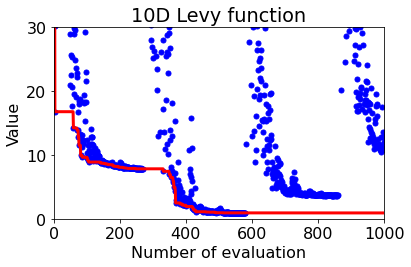

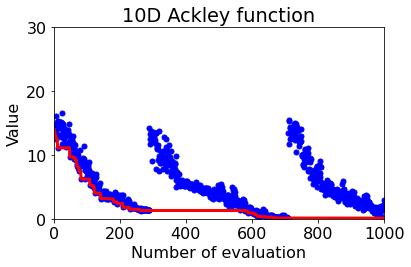

In [210]:
for key in ["levy_0_turbo", "ackley_0_turbo"]:
    fX = plot_results[key]
    func = key.split('_')[0]
    
    ylim = 30
    if func == 'ackley':
        ylim = 15
    
    matplotlib.rcParams.update({'font.size': 16})
    plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
    plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
    plt.xlim([0, len(fX)])
    plt.ylim([0, ylim])
    plt.title("10D {} function".format(func.capitalize()))
    
    plt.xlabel("Number of evaluation")
    plt.ylabel("Value")
    
    plt.tight_layout()
    plt.savefig("../results/3_albo_{}.pdf".format(func))
    plt.show()

###  For 200 Dimension


In [213]:
results = {}
plot_results = {}

dimension=200
for func in ["ackley"]:
    if func == "levy":
        f = Levy(dimension)
    else :
        f = Ackley(dimension)
    
    api_config = {}
    for i in range(dimension):
        api_config["dim_"+str(i)] = {"type" : "real", "space" : "linear", "range" : (f.lb[0], f.ub[0])}     

    min_result = np.zeros(0)
    for random_seed in range(5):
                
        print("="*20)
        print("Seed : ", random_seed)
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Optimize
        AT = AdvancedTurbo(api_config)
        AT.optimize(f, num_evals=50, n_suggestions=10)

        # Collect Minimum value
        fX = AT.turbo.fX
        min_result = np.concatenate((min_result, min(fX)))
        plot_results[func+'_'+str(random_seed)] = fX.tolist()
        
    results[func] = min_result.tolist()


Seed :  0
Evaluation iter : 0, yy minimum : 13.65991419252243
Evaluation iter : 22, yy minimum : 13.603401941631128
Evaluation iter : 40, yy minimum : 13.461294892954164
Evaluation iter : 41, yy minimum : 13.299525248436805
Evaluation iter : 42, yy minimum : 13.16255683711756
Evaluation iter : 43, yy minimum : 12.997042008660598
Evaluation iter : 44, yy minimum : 12.848440034367911
Evaluation iter : 45, yy minimum : 12.783706456430988
Evaluation iter : 46, yy minimum : 12.658806162928803
Evaluation iter : 47, yy minimum : 12.549730070955835
Evaluation iter : 48, yy minimum : 12.45344983699754
Evaluation iter : 49, yy minimum : 12.360042127014173
Seed :  1
Evaluation iter : 0, yy minimum : 13.449816234773817
Evaluation iter : 24, yy minimum : 13.11727968555025
Evaluation iter : 40, yy minimum : 13.03024873908506
Evaluation iter : 41, yy minimum : 12.867591836375322
Evaluation iter : 42, yy minimum : 12.74677743705951
Evaluation iter : 43, yy minimum : 12.643617783959442
Evaluation iter 